In [1]:
import re
from difflib import SequenceMatcher

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Import Data

### Download the dataset here:  https://grouplens.org/datasets/movielens/

Download the dataset under the section "Recommended for education and development".
The dataset is in .zip format. Extract the contents of the zip file and remane as ml-latest-small as data. 

## Import movies.csv and drop the genres column 


In [2]:
movies = pd.read_csv('data/movies.csv')
movies = movies.drop(['genres'], axis = 'columns')

## Import ratings.csv and drop the timestamp column.  

In [3]:
ratings = pd.read_csv('data/ratings.csv')
ratings = ratings.drop(['timestamp'], axis = 'columns')

## View the contents of the dataset 

In [4]:
movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [5]:
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


## View how the movies are rated: 

In [6]:
ratings['rating'].sort_values().unique()

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

## Find out the number of movies

In [7]:
movies.values.shape[0]

9742

## Total number of ratings: 

In [8]:
ratings.values.shape[0]

100836

## Number of unique ratings: 

In [9]:
ratings['userId'].nunique()

610

# Data Preprocessing and Visualization 

## The long tail property: 
A general trend observed in statistics and business is that a small percentage of entities are highly popular and the rest are not as popular 

### Set threshold for popular movies and active users 

In [10]:
popular_movies_thresh = 25
active_users_thresh = 100

### Visualize the long tail property for popular movies 

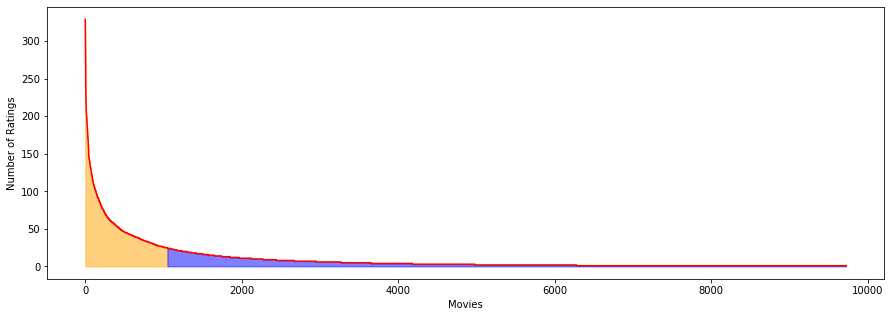

In [11]:
movies_count = pd.DataFrame(ratings.groupby('movieId').size().sort_values(ascending = False), columns = ['count'])

divider = len(movies_count.query('count >= @popular_movies_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize = (15,5))    
plt.plot(np.arange(len(movies_count)), movies_count['count'], color = 'red')
plt.xlabel('Movies')
plt.ylabel('Number of Ratings')

ax.fill_between(np.arange(0, divider),
               0, 
               movies_count['count'][:divider],
               color = 'orange', 
               alpha = 0.5)

ax.fill_between(np.arange(divider, len(movies_count)),
               0, 
               movies_count['count'][divider:],
               color = 'blue', 
               alpha = 0.5)


## Remove unpopular movies from the dataset

In [12]:
popular_movies_indices = movies_count.query('count >= @popular_movies_thresh').index
popular_ratings = ratings[ratings['movieId'].isin(popular_movies_indices)]

## Number of row before and after removing unpopular movies

In [13]:
ratings.shape[0]

100836

In [14]:
popular_ratings.shape[0]

62518

### Number of distinct movies before and after removing unpopular movies 

In [15]:
ratings.groupby('movieId').count().shape[0]

9724

In [16]:
popular_ratings.groupby('movieId').count().shape[0]

1050

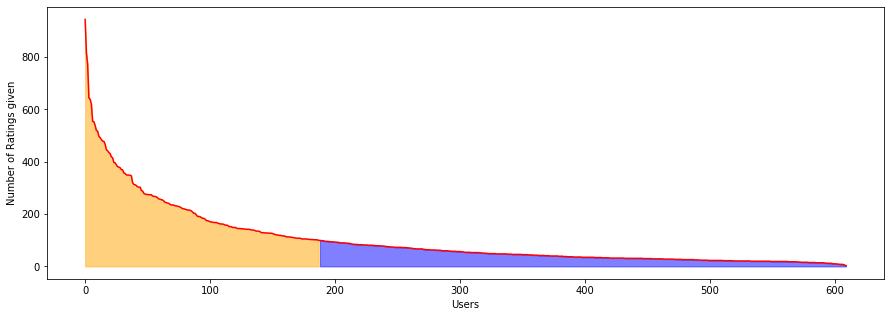

In [17]:
users_count = pd.DataFrame(popular_ratings.groupby('userId').size().sort_values(ascending = False), columns = ['count'])
divider = len(users_count.query('count >= @active_users_thresh'))
fig, (ax) = plt.subplots(1, 1, figsize = (15,5))    
plt.plot(np.arange(len(users_count)), users_count['count'], color = 'red')
plt.xlabel('Users')
plt.ylabel('Number of Ratings given')

ax.fill_between(np.arange(0, divider),
               0, 
               users_count['count'][:divider],
               color = 'orange', 
               alpha = 0.5)

ax.fill_between(np.arange(divider, len(users_count)),
               0, 
               users_count['count'][divider:],
               color = 'blue', 
               alpha = 0.5)


## Remove non active users fron the data

In [18]:
active_users_indices = users_count.query("count >= @active_users_thresh").index
active_users_ratings = popular_ratings[popular_ratings['userId'].isin(active_users_indices)]

### Number of rows in rating data after removing unpopular movies 

In [19]:
popular_ratings.shape[0]

62518

### Active users 

In [20]:
active_users_ratings.shape[0]

44588

### Number of users before removing inactive users

In [21]:
popular_ratings.groupby('userId').count().shape[0]

610

### Number of users after removing inactive users and unpopular movies

In [22]:
active_users_ratings.groupby('userId').count().shape[0]

188

## Create a pivot table with rows containing movie ID and columns containing user ID. The cells in the table will contain the rating given by the user to the movie. 


In [23]:
pivot_table = active_users_ratings.pivot(index = 'movieId', columns = 'userId', values = 'rating').fillna(0)

## Number of movies in the pivot table

In [24]:
pivot_table.index.shape[0]

1050

## Number of columns in the pivot table

In [25]:
pivot_table.columns.shape[0]

188

In [26]:
pivot_table.head()

userId,1,4,6,7,15,18,19,20,21,22,...,597,599,600,602,603,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,2.5,3.5,4.0,0.0,3.5,0.0,...,4.0,3.0,2.5,0.0,4.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,3.0,3.0,3.0,3.5,0.0,...,0.0,2.5,4.0,4.0,0.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,3.0,4.5,0.0,3.0,4.0,0.0,0.0,0.0,0.0,5.0


## Create a sparse matrix for the pivot table

In [27]:
sparse_matrix = csr_matrix(pivot_table.values) 

## Create dictionaries ( mapping ) for:
    movieId --> movie title
    movie Title --> movieId

In [28]:
pivot_table_movies = movies.set_index('movieId').loc[pivot_table.index]['title'].values
title_to_id = {movie : i for i, movie in enumerate(pivot_table_movies)}

In [29]:
id_to_title = {v : k for k, v in title_to_id.items()}

# Train the model: 

## We use the K - Nearest Algorithm. The sparse matrix is provided as the dataset to the algorithm. 

#### Cosine Similarity: 
Cosine similarity is a measure of the similarity between 2 non - zero vectors of an inner product space that measures the cosine of the angle between them. 

#### Why not Eucledian Distance?
Number of columns in the data is of the order of hundreds and the matrix is very sparse. It would be highly inaccurate and inefficient to use the Eucledian Distance.

#### Note: 
The nearest neighbours algorithm is a LAZY LEARNER. We call the fit function here because internally, the appropriate data structure has to be set up for fast lookup and computation of similarity metric. 


In [30]:
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

# Get recommendations: 

## Define a function to search for similar movie titles for a given keyword.
The keyword provided may not be the exact title of the movie. Therefore, we will use the SequenceMatcher to perform the search.
Here, we will select the top 10 most similar movie titles for the given search keyword.

In [1]:
def find_matches(title_to_id, movie_title):
    movie_ids = np.array(list(title_to_id.values())).astype(int)
    titles = np.array(list(title_to_id.keys()))
    ratios = list()
    for title, movie_id in title_to_id.items():
        ratio = SequenceMatcher(None, movie_title, title, autojunk = False).ratio()
        ratios.append(ratio)
    titles, ids = titles[np.argsort(ratios)][-10:], movie_ids[np.argsort(ratios)][-10:]
    return(list(reversed(list(zip(titles, ids)))))

# Given a title of a movie, we will display a dropdown to display the options and to select the title

In [32]:
title = input("Enter the name of the movie : ")
options = find_matches(title_to_id, title)

import ipywidgets as widgets
drop = widgets.Dropdown(options = options)
drop

Enter the name of the movie : wizard of oz


Dropdown(options=(('Wizard of Oz, The (1939)', 212), ('Die Hard 2 (1990)', 329), ('Lord of War (2005)', 867), …

# Show recommendations for a given movie
For the given movie, the similarity measure between the given model all the samples in the dataset is computed. 
n_neighbours how many similar movies are shown as recommendation.

In [33]:
movie_id = drop.value
test = pivot_table.iloc[movie_id, :].values.reshape(1, -1)

distances, indices = model_knn.kneighbors(test, n_neighbors = 10 + 1)

indices = indices.squeeze()[1:]

print('Recommendations for :', id_to_title[movie_id])
for i, index in enumerate(indices): 
    print(i + 1, '.', id_to_title[index])

Recommendations for : Wizard of Oz, The (1939)
1 . Willy Wonka & the Chocolate Factory (1971)
2 . Mary Poppins (1964)
3 . E.T. the Extra-Terrestrial (1982)
4 . Monty Python and the Holy Grail (1975)
5 . Jaws (1975)
6 . Breakfast Club, The (1985)
7 . Toy Story (1995)
8 . Back to the Future (1985)
9 . Silence of the Lambs, The (1991)
10 . Who Framed Roger Rabbit? (1988)
